In [24]:
import os
from dotenv import load_dotenv
from typing import TypedDict, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_groq.chat_models import ChatGroq
from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
groq_api_key = os.getenv('GROQ_API_KEY')
llm = ChatGroq(groq_api_key=groq_api_key, model="llama-3.3-70b-versatile")

llm.invoke("hi").content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [3]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [4]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
doc_splitter = text_splitter.split_documents(docs_list)

vectorstore = Chroma.from_documents(
    documents=doc_splitter,
    collection_name="rag",
    embedding=embeddings
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 2})

#### Let's create a RAG chain now

In [5]:
template = """ 
You are an assistant for question-answering task. Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know. Use three sentences maximun and keep the answer concise.
\nQuestion: {question} \nContext: {context} \nAnswer:
"""

prompt = PromptTemplate(
    template=template,
    input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | llm | StrOutputParser()

In [6]:
question = "tell me about agent memory"
rag_chain.invoke({"context": docs[0], "question": question})

'In the context of LLM-powered autonomous agents, memory refers to the processes used to acquire, store, retain, and retrieve information. There are two types of memory: short-term memory, which utilizes in-context learning and has a limited capacity, and long-term memory, which provides the capability to retain and recall information over extended periods using an external vector store and fast retrieval.'

#### Now lets create grade document class

In [7]:
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    
    binary_score: str = Field(
        description="Documents are relevant to the question 'yes' or 'no'"
    )

In [8]:
structured_llm_grader = llm.with_structured_output(GradeDocuments)

system_msg = """ You are a grader accessing relevance of a retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to question, grade it as relevant. \n
Give binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_msg),
        ("user", "Retrieved document: \n\n{document} \n\n User question: {question}")
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [9]:
question = "tell me about agent memory"
docs = retriever.get_relevant_documents(question)

doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

C:\Users\sowmy\AppData\Local\Temp\ipykernel_30076\3694875819.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


binary_score='yes'


In [10]:
question = "Who built taj Mahal"
docs = retriever.get_relevant_documents(question)

doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


#### Let's create Question Re-Writer

In [11]:
system_msg = """You are a question re-writer that converts an input question to better version that is optimized \n
for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_msg),
        ("user", 
         "Here is the initial question: \n\n {question} \n Formulate an improved quesiton.")
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [12]:
question_rewriter.invoke({"question": question})

'Here\'s a reformulated version of the question that\'s more optimized for web search:\n\n"Who was the architect and builder of the Taj Mahal in India?"\n\nAlternatively, you could also try:\n\n* "Taj Mahal construction: Who was the main architect and builder?"\n* "History of the Taj Mahal: Who designed and built the monument?"\n* "Taj Mahal builders: Who was responsible for constructing the Taj Mahal in Agra, India?"\n\nThese revised questions are more specific and include relevant keywords like "architect", "builder", "India", and "Agra", which can help search engines provide more accurate and relevant results.'

#### Let's create required function

In [13]:
def retrieve(state):
    """ 
    Retrieve documents 
    
    Args: 
        state (dict): The current graph state 
        
    Returns:
    """
    print("---RETRIEVE---")
    
    question = state['question']
    documents = retriever.get_relevant_documents(question)
    
    return {"documents": documents, "question": question}

In [14]:
def grade_document(state):
    """ 
    Determines whether the retrieved documents are relevant to the question.
    
    Args:
        state (dict): The current graph state 
        
    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """
    print("---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT")
    
    question = state['question']
    documents = state['documents']
    
    filtered_docs = [] 
    web_search = "No"
    
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score 
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENTS NOT RELEVANT")
            web_search = "Yes"
            continue 
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

In [15]:
def generate(state):
    """ 
    Generate answer
    
    Args: 
        state (dict): The current graph state 
        
    Returns:
        state (dict): new key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    
    question = state['question']
    documents = state['documents']
    
    generation = rag_chain.invoke({"context": documents, "question": question})
    
    return {"documents": documents, "question": question, "generation": generation}

In [16]:
def transform_query(state):
    """ 
    Transform the query to produce a better question.
    
    Args:
        state (dict): The current graph state 
        
    Returns:
        state (dict): Updates question key with a re-phrased question
    """
    print("---TRANSFORM QUERY---")
    
    question = state['question']
    documents = state['documents']
    
    better_question = question_rewriter.invoke({"question": question})
    
    return {"documents": documents, "question": better_question}

#### Web crawling we gonna perform using Tavily

In [17]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

In [18]:
from langchain.schema import Document

def web_search(state):
    """ 
    Web search based on the re-phrased question.
    
    Args:
        state (dict): The current graph state 
        
    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    
    question = state['question']
    documents = state['documents']
    
    docs = web_search_tool.invoke({"query": question})
    
    web_results = "\n".join([d['content'] for d in docs])
    
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    
    return {"documents": documents, "question": question}

In [19]:
def decide_to_generate(state):
    """ 
    Determine whether to generate an answer, or re-generate a question.
    
    Args:
        state (dict): The current graph state 
        
    Returns:
        str: Binary dicision for next node to call
    """
    print("---ACCESS GRADED DOCUMENTS---")
    
    web_search = state['web_search']
    
    if web_search == "Yes":
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---")
        
        return "transform_query"
    
    else:
        print("---DECISION: GENERATE---")
        return "generate"

In [22]:
class State(TypedDict):
    """ 
    Represents the state of our graph.
    
    Attributes:
        question: question
        genration: LLM generation
        web_search: whether to add search 
        documents: list of documents
    """
    
    question: str 
    generation: str
    web_search: str 
    documents: List[str]
    
    
workflow = StateGraph(State)

In [23]:
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_document)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)

In [25]:
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")

workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate"
    }
)

workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")

workflow.add_edge("generate", END)

In [26]:
app = workflow.compile()

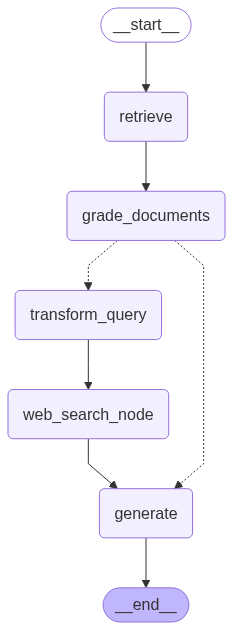

In [27]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [28]:
from pprint import pprint

inputs = {"question": "tell me about the agent memory."}

In [29]:
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node {key} :")
        
    pprint("\n---\n")
    
pprint(value["generation"])

---RETRIEVE---
'Node retrieve :'
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ACCESS GRADED DOCUMENTS---
---DECISION: GENERATE---
'Node grade_documents :'
'\n---\n'
---GENERATE---
'Node generate :'
'\n---\n'
('The agent memory consists of two types: short-term memory and long-term '
 'memory. Short-term memory utilizes in-context learning, while long-term '
 'memory retains and recalls information over extended periods using an '
 'external vector store. This allows the agent to learn and recall '
 'information, with long-term memory providing the capability to retain '
 'infinite information.')
